In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
SEED = 666

## 1. Data Cleaning (if any)

In [2]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTEN, SMOTENC

In [4]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [5]:
df = df.rename(columns={'HeartDiseaseorAttack': 'y'})

In [6]:
df.columns

Index(['y', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income'],
      dtype='object')

In [7]:
# stratify_columns = ['y', 'Education']
# train, test = train_test_split(df, test_size=0.15, stratify=df[stratify_columns], random_state=SEED)
# test.to_csv('hold_out.csv', index=False)
# train.to_csv('train.csv', index=False)

In [8]:
train = pd.read_csv('train.csv')

In [9]:
train.head()

,y,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
1,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
2,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,5.0,6.0
3,0.0,1.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,4.0,7.0
4,0.0,1.0,0.0,1.0,35.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,4.0,4.0,15.0,1.0,0.0,3.0,4.0,4.0


<AxesSubplot:xlabel='BMI', ylabel='Density'>

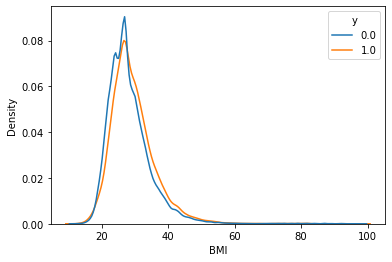

In [10]:
sns.kdeplot(data=train, x = 'BMI', hue = 'y', common_norm=False)

In [15]:
def plot_pairwise(train):
    fig, axs = plt.subplots(6, 4, figsize = (12, 9))
    axs = axs.flatten()
    features = train.drop('y', axis=1).columns
    for i, f in enumerate(features):
        to_display = train.groupby(f)[['y']].mean()
        if to_display.shape[0] < 10:
            to_display = to_display.rename(columns = {'y':'disease_proportion'})
            to_display.plot(kind='bar', ax=axs[i], legend = False)
        else:
#             to_display.plot(kind='line', ax=axs[i], legend = False)
            sns.kdeplot(data = train, x = f, hue = 'y', ax=axs[i], common_norm=False)
    plt.tight_layout()

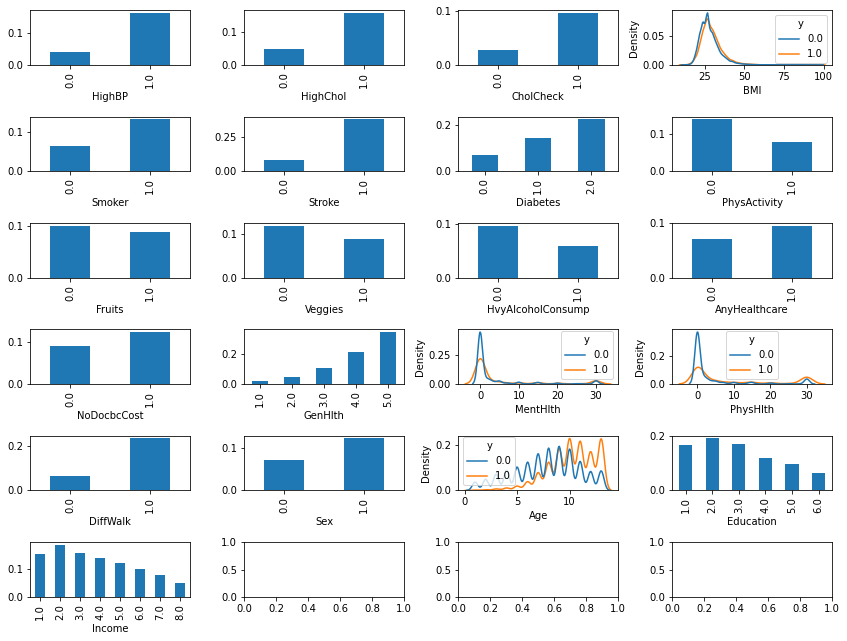

In [16]:
plot_pairwise(train)

In [17]:
X_train, y_train = train.drop('y', axis = 1), train['y']

### TODO:
1. Over/undersampling to balance
2. Algorithmically adjust for imbalance in model

## 2. Data-centric adjustments

### 2.1 Oversampling using SmoteNC (nominal continuous)

In [186]:
cont_features = [3, 14, 15, 18]

In [187]:
smote_nc = SMOTENC(categorical_features = list(set(range(len(X_train.columns))) - set(cont_features)), random_state=SEED)

In [188]:
smote_nc

SMOTENC(categorical_features=[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17,
                              19, 20],
        random_state=666)

In [189]:
X_train_resampled, y_trainresampled = smote_nc.fit_resample(X_train, y_train)

In [190]:
train_resampled = X_train_resampled.copy()
train_resampled['y'] = y_trainresampled

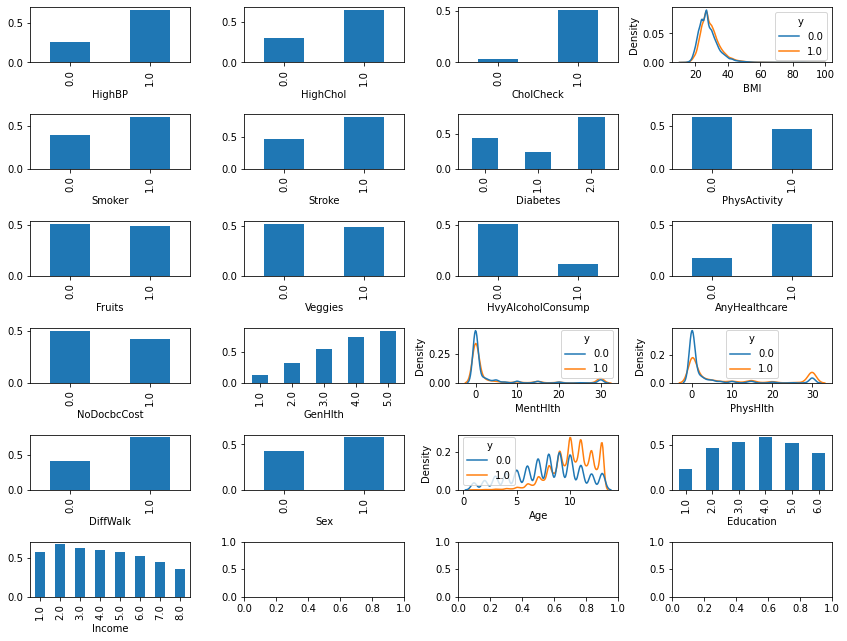

In [191]:
plot_pairwise(train_resampled)

Note how features like NoDocbcCost has the relationship of positive ratio flipped between the two classes. Similarly, the distribution of disease rate among features like education also shifts

## 3 Model-centric approach

In [85]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate

In [38]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### 3.1 Setting a baseline model
A logistic regression with adjusted class weight (normalized by proportion, conveniently dubbed 'balanced' in sklearn)

The default solver lbfgs has problem converging. Try:
1. raising iterations 
2. using a first order solver (trading performance for convergence)
- Note that if choosing solvers that require random shuffling of data, random_state needs to be stipulated to ensure convergence on every run 

In [47]:
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

In [57]:
lr = LogisticRegressionCV(Cs = Cs, 
                          class_weight='balanced', 
                          scoring = 'f1', 
                          solver='sag',
                          random_state = 666,
                          cv=3)

In [58]:
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0],
                     class_weight='balanced', cv=3, random_state=666,
                     scoring='f1', solver='sag')

In [59]:
pd.DataFrame(lr.scores_[1],columns=[f'C = {str(c)}' for c in Cs])

,C = 0.0001,C = 0.001,C = 0.01,C = 0.1,C = 1,C = 10.0,C = 100.0
0,0.357659,0.372914,0.375297,0.375804,0.375730,0.375743,0.375756
1,0.358746,0.372642,0.375444,0.375952,0.376035,0.376048,0.376048
2,0.361821,0.376258,0.378614,0.378833,0.378883,0.378953,0.378923


In [81]:
feature_importance = pd.DataFrame(
    [(feature, np.exp(lr.coef_[0][i])) for i,feature in enumerate(X_train.columns)],
    columns=['feature', 'increase in odd']).sort_values(by = 'increase in odd', ascending=False)
feature_importance

,feature,increase in odd
5,Stroke,3.066368
17,Sex,2.236024
1,HighChol,1.883320
2,CholCheck,1.770328
0,HighBP,1.746313
13,GenHlth,1.644563
4,Smoker,1.457821
16,DiffWalk,1.373383
12,NoDocbcCost,1.325868
18,Age,1.317211


### 3.2 Treating the problem as an outlier detection problem

In [135]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from copy import deepcopy

In [113]:
def binary_to_outlier(y):
    y = deepcopy(y)
    y[y==1] = -1
    y[y==0] = 1
    return y

In [173]:
def outlier_to_binary(y):
    y = deepcopy(y)
    y[y==1] = 0
    y[y==-1] = 1
#     print(f'transformed: {np.sum(y)}')
    return y

In [174]:
def custom_f1_scorer(y, y_pred):
    print(np.sum(y), np.sum(y_pred==-1))
    y_pred = outlier_to_binary(y_pred)
#     print(np.sum(y_pred==1))
    return f1_score(y, y_pred)

In [183]:
outlier_svm = SGDOneClassSVM(nu=1, random_state=666)

In [184]:
cross_validate(outlier_svm, X_train, y_train, cv=2, scoring=make_scorer(custom_f1_scorer))

10218.0 2980
10091.0 3044


{'fit_time': array([0.14702487, 0.14352489]),
 'score_time': array([0.04050732, 0.04100752]),
 'test_score': array([0.02030611, 0.01903312])}

In [192]:
cross_validate(LocalOutlierFactor(novelty=True), X_train, y_train, cv=2, scoring=make_scorer(custom_f1_scorer))

C:\Users\lishu\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


10218.0 1057


C:\Users\lishu\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


10091.0 723


{'fit_time': array([246.62817311, 241.57428837]),
 'score_time': array([247.24341297, 234.96163034]),
 'test_score': array([0.00177384, 0.00073978])}

In [193]:
cross_validate(IsolationForest(), X_train, y_train, cv=2, scoring=make_scorer(custom_f1_scorer))

10218.0 37956
10091.0 37596


{'fit_time': array([1.61378145, 1.5627737 ]),
 'score_time': array([3.75815868, 3.72365117]),
 'test_score': array([0.26308797, 0.26229371])}

nah not good enough

### 3.3 Rabbit hole

## Second iteration: 
feature engineering and selection